<a href="https://colab.research.google.com/github/esuda/mineiracao_dados_complexos/blob/master/Big_Data_010_Aula_03_Padr%C3%B5es_MapReduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instruções iniciais** 

*   Abra o link dos dados: 
    *   https://tinyurl.com/bd10-gut
    *   https://tinyurl.com/bigdata-amz
*   Clique em "Adicionar ao Drive"

In [ ]:
!pip install mrjob

     |████████████████████████████████| 439 kB 5.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Contagem de Palavras

In [ ]:
%%file word_count.py
from mrjob.job import MRJob
import re

class WordCount(MRJob):

    def mapper(self, _, line):
        line = re.sub('[^a-zà-ù ]', ' ', line.lower())
        for word in line.split() :
            yield word, 1

    def reducer(self, key, values):
        yield key, sum(values)

if __name__ == '__main__':
    WordCount.run()

In [ ]:
!python word_count.py "/content/drive/My Drive/gut-pt/small"

In [ ]:
!python word_count.py -r local "/content/drive/My Drive/gut-pt/small" --output-dir "/content/drive/My Drive/bigdata-tmp"

In [ ]:
!cat "/content/drive/My Drive/bigdata-tmp/"*

In [ ]:
%%file word_count_combiner.py
from mrjob.job import MRJob
from mrjob.protocol import TextProtocol
import re

class WordCount(MRJob):

    OUTPUT_PROTOCOL = TextProtocol

    def mapper(self, _, line):
        line = re.sub('[^a-z ]', ' ', line.lower())
        for word in line.split() :
            yield word, 1

    def combiner(self, key, values):
        yield key, sum(values)

    def reducer(self, key, values):
        yield key, str(sum(values))


if __name__ == '__main__':
    WordCount.run()


In [ ]:
!python word_count_combiner.py -r local "/content/drive/My Drive/gut-pt/small" --output-dir "/content/drive/My Drive/bigdata-tmp"

In [ ]:
!cat "/content/drive/My Drive/bigdata-tmp/"*

  # Cálculo de Média






In [ ]:
!head -n 10 "/content/drive/My Drive/amz/small.csv"

In [ ]:
%%file avg_product_review.py
from mrjob.job import MRJob

class AvgProductReview(MRJob):

    def mapper(self, _, line):
        item,user,rating,timestamp = line.split(',')
        yield item, float(rating)

    def reducer(self, key, values):
        vlist = list(values)
        yield key, sum(vlist)/len(vlist)

if __name__ == '__main__':
    AvgProductReview.run()

In [ ]:
!python avg_product_review.py -r local "/content/drive/My Drive/amz/small.csv"

In [ ]:
%%file avg_product_review_combiner.py

from mrjob.job import MRJob

class AvgProductReview(MRJob):

    def mapper(self, _, line):
        item,user,rating,timestamp = line.split(',')
        yield item, float(rating)

    def combiner(self, key, values) :
        for v in values :
          yield key, v        

    def reducer(self, key, values):
        vlist = list(values)
        yield key, sum(vlist)/len(vlist)

if __name__ == '__main__':
    AvgProductReview.run()

In [ ]:
!python avg_product_review_combiner.py -r local "/content/drive/My Drive/amz/small.csv" 

**Pare aqui!**

Implemente o cálculo de média com combiner antes de continuar

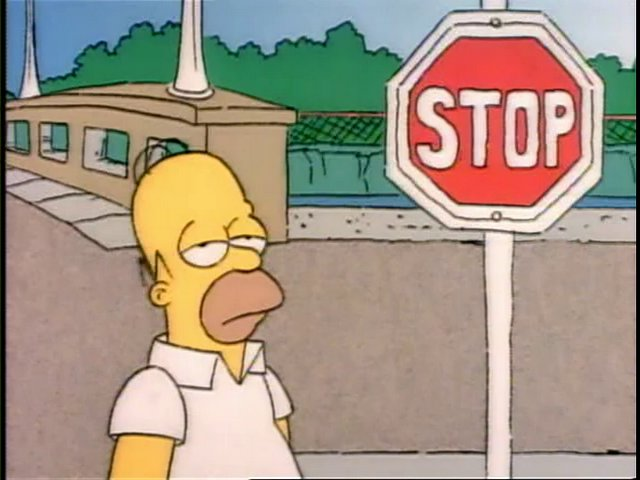

In [ ]:
%%file avg_product_review_combiner.py

from mrjob.job import MRJob

class AvgProductReview(MRJob):

    def mapper(self, _, line):
        item,user,rating,timestamp = line.split(',')
        yield item, [float(rating), 1]

    def combiner(self, key, values) :
        s = 0.0
        c = 0
        for v in values :
            s = s + v[0]
            c = c + v[1]
        yield key, [s, c]

    def reducer(self, key, values):
        s = 0.0
        c = 0
        for v in values :
            s = s + v[0]
            c = c + v[1]
        yield key, s/c

if __name__ == '__main__':
    AvgProductReview.run()


In [ ]:
!python avg_product_review_combiner.py -r local "/content/drive/My Drive/amz/Toys_and_Games.csv" --output-dir "/content/drive/My Drive/bigdata-tmp"

# Ordenação

In [ ]:
%%file word_count_sort.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import TextProtocol
import re

class WordCount(MRJob):

    OUTPUT_PROTOCOL = TextProtocol

    def steps(self):
        return [
            MRStep(mapper=self.mapper,
            combiner=self.combiner,
            reducer=self.reducer),
            MRStep(reducer=self.reducer_order)
        ]

    def mapper(self, _, line):
        line = re.sub('[^a-zà-ù ]', ' ', line.lower())
        for word in line.split() :
            yield word, 1

    def combiner(self, key, values):
        yield key, sum(values)

    def reducer(self, key, values):
        yield str(sum(values)), key

    def reducer_order(self, total, words) :
        for w in words :
          yield w, total


if __name__ == '__main__':
    WordCount.run()

In [ ]:
!rm '/content/drive/My Drive/tmp9/'*

In [ ]:
!python word_count_sort.py "/content/drive/My Drive/gut-pt/small" --output-dir='/content/drive/My Drive/tmp9'

In [ ]:
!ls '/content/drive/My Drive/tmp9/'

In [ ]:
!tail -n 30 '/content/drive/My Drive/tmp9/part-00002' 

**Pare aqui!**

Implemente a sua solução para ordenação com múltiplos jobs/passos antes de continuar

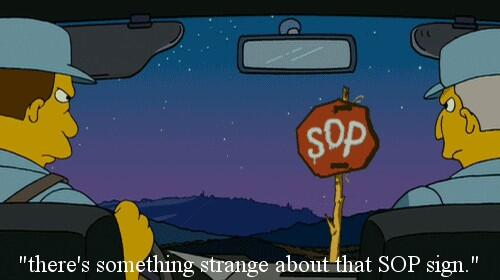

In [ ]:
%%file word_count_sort.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re

class WordCount(MRJob):

    def steps(self):
        return [
            MRStep(mapper=self.mapper,
            combiner=self.combiner,
            reducer=self.reducer),
            MRStep(reducer=self.reducer_order)
        ]

    def mapper(self, _, line):
        line = re.sub('[^a-z ]', ' ', line.lower())
        for word in line.split() :
            yield word, 1

    def combiner(self, key, values):
        yield key, sum(values)

    def reducer(self, key, values):
        yield str(sum(values)).zfill(9), str(key)

    def reducer_order(self, total, words) :
        for w in words :
            yield w, total


if __name__ == '__main__':
    WordCount.run()

In [ ]:
!python word_count_sort.py "/content/drive/My Drive/gut-pt/small" --output-dir='/content/drive/My Drive/tmp-sort'

In [ ]:
!tail -n 30 '/content/drive/My Drive/tmp-sort/part-00002' 

# Join (reduce-side)

In [ ]:
!head "/content/drive/My Drive/amz/meta_small.json"

In [ ]:
%%file avg_brand_review.py
from mrjob.job import MRJob
import json

class AvgBrandReview(MRJob):

    def mapper(self, _, line):
        if len(line) > 50 :
            dict = json.loads(line)
            try :
                yield dict['asin'], [dict['brand']]
            except :
                pass
        else :
            item,user,rating,timestamp = line.split(',')
            yield item, [float(rating), 1]

    def reducer(self, key, values):
        brand = None
        nreviews = 0
        score = 0.0
        for v in values :
            if len(v) > 1 :
                nreviews = nreviews + v[1]
                score = score + v[0]
            else :
                brand = v[0]
        if brand != None and nreviews > 0 :
            yield brand, score/nreviews

if __name__ == '__main__':
    AvgBrandReview.run()

In [ ]:
!python avg_brand_review.py -r local "/content/drive/My Drive/amz/small.csv" "/content/drive/My Drive/amz/meta_small.json" --output-dir="/content/drive/My Drive/tmp9"

In [ ]:
!tail -n 20 "/content/drive/My Drive/tmp9/part-00001"

In [ ]:
%%file avg_brand_review_reduce.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import json

class AvgBrandReview(MRJob):

    def steps(self):
        return [
            MRStep(mapper=self.mapper,
            reducer=self.reducer),
            MRStep(reducer=self.reducer_brand)
        ]

    def mapper(self, _, line):
        if len(line) > 50 :
            dict = json.loads(line)
            try :
                yield dict['asin'], [dict['brand']]
            except :
                pass
        else :
            item,user,rating,timestamp = line.split(',')
            yield item, [float(rating), 1]

    def reducer(self, key, values):
        brand = None
        nreviews = 0
        score = 0.0
        for v in values :
            if len(v) > 1 :
                nreviews = nreviews + v[1]
                score = score + v[0]
            else :
                brand = v[0]
        if brand != None and nreviews > 0 :
            yield brand, [score, nreviews]

    def reducer_brand(self, key, values) :
        score = 0.0
        nreviews = 0
        for v in values :
            score = score + v[0]
            nreviews = nreviews + v[1]
        avg = round(score/nreviews,2)
        if nreviews > 20 :
            yield key, "{:.2f}".format(avg)

if __name__ == '__main__':
    AvgBrandReview.run()

In [ ]:
!python avg_brand_review_reduce.py -r local "/content/drive/My Drive/amz/small.csv" "/content/drive/My Drive/amz/meta_small.json" --output-dir="/content/drive/My Drive/tmp9"

In [ ]:
!tail -n 20 "/content/drive/My Drive/tmp9/part-00000"

**Pare aqui!**

Adicione um passo de ordenação para o script de avaliação de marcas

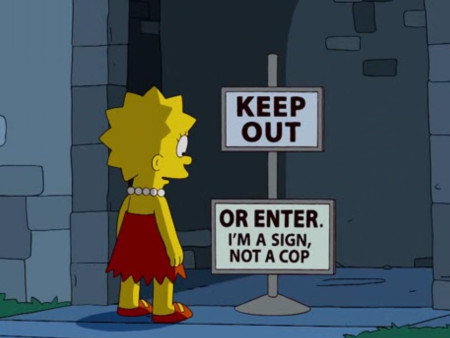

In [ ]:
%%file avg_brand_review_order.py


from mrjob.job import MRJob
from mrjob.step import MRStep
import json

class AvgBrandReview(MRJob):

    def steps(self):
        return [
            MRStep(mapper=self.mapper,
            reducer=self.reducer),
            MRStep(reducer=self.reducer_brand),
            MRStep(reducer=self.reducer_order)
        ]

    def mapper(self, _, line):
        if len(line) > 50 :
            dict = json.loads(line)
            try :
                yield dict['asin'], [dict['brand']]
            except :
                pass
        else :
            item,user,rating,timestamp = line.split(',')
            yield item, [float(rating), 1]

    def reducer(self, key, values):
        brand = None
        nreviews = 0
        score = 0.0
        for v in values :
            if len(v) > 1 :
                nreviews = nreviews + v[1]
                score = score + v[0]
            else :
                brand = v[0]
        if brand != None and nreviews > 0 :
            yield brand, [score, nreviews]

    def reducer_brand(self, key, values) :
        score = 0.0
        nreviews = 0
        for v in values :
            score = score + v[0]
            nreviews = nreviews + v[1]
        avg = round(score/nreviews,2)
        if nreviews > 100 :
            yield "{:.2f}".format(avg), key

    def reducer_order(self, score, brand) :
        for b in brand :
            yield b, score

if __name__ == '__main__':
    AvgBrandReview.run()

In [ ]:
!python avg_brand_review_order.py -r local "/content/drive/My Drive/amz/small.csv" "/content/drive/My Drive/amz/meta_small.json" --output-dir "/content/drive/My Drive/tmp9"

In [ ]:
!ls "/content/drive/My Drive/tmp9"

In [ ]:
!tail -n 100 "/content/drive/My Drive/tmp9/part-00003"

# Indices

In [ ]:
%%file product_index.py


from mrjob.job import MRJob
import json
import re

class ProductIndex(MRJob):

    stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves",
    "you", "your", "yours", "yourself", "yourselves", "he", "him", "his",
    "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they",
    "them", "their", "theirs", "themselves", "what", "which", "who", "whom",
    "this", "that", "these", "those", "am", "is", "are", "was", "were", "be",
    "been", "being", "have", "has", "had", "having", "do", "does", "did",
    "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as",
    "until", "while", "of", "at", "by", "for", "with", "about", "against",
    "between", "into", "through", "during", "before", "after", "above",
    "below", "to", "from", "up", "down", "in", "out", "on", "off", "over",
    "under", "again", "further", "then", "once", "here", "there", "when",
    "where", "why", "how", "all", "any", "both", "each", "few", "more", "most",
    "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]



    def mapper(self, _, line):
        dict = json.loads(line)
        try :
            text = dict['reviewText']
            product = dict['asin']
            text = re.sub('[^a-z ]', ' ', text.lower())
            for word in text.split() :
                if word not in self.stopwords :
                    yield word, product
        except :
            pass


    def combiner(self, key, values):
        pset = set(values)
        for p in pset :
            yield key, p

    def reducer(self, key, values):
        pset = set(values)
        yield key, list(pset)

if __name__ == '__main__':
    ProductIndex.run()

In [ ]:
!python product_index.py -r local "/content/drive/My Drive/amz/small.json" --output-dir=tmp9

In [ ]:
!cat tmp9/* | grep great